In [2]:
from google.colab import drive
drive.mount('/content/drive')

# make path = './' in-case you are running this locally
path = '/content/drive/My Drive/'
print(path) 

Mounted at /content/drive
/content/drive/My Drive/


# PCA toy example

In [3]:
import sklearn
from sklearn import datasets
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

(30, 4096)
[0 1 2]


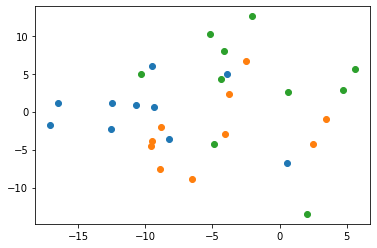

In [4]:
# Create data; 3 clusters with 64^2 features
data, labels = datasets.make_blobs(n_samples = 30, n_features=64*64, centers=3, cluster_std=5)

print(data.shape) # (num_samples, num_features) (30, 4096) # (1, 4096)
print(np.unique(labels))

plt.figure()
plt.scatter(data[labels==0, 0], data[labels==0, 1])
plt.scatter(data[labels==1, 0], data[labels==1, 1])
plt.scatter(data[labels==2, 0], data[labels==2, 1])
plt.show()

Original Data Space: (30, 4096)
PCA projected Data Space: (30, 30)


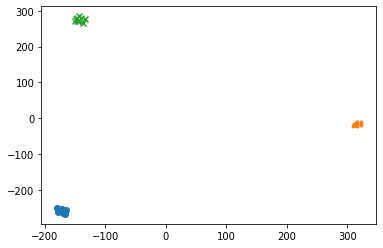

In [5]:
# Get PCA decomposition

pca = PCA(n_components=30)
pca.fit(data)

# original data shape (30, 4096) this is (Num_samples, dimension of each samples)
# we transfer that into (30, 30) this is (Num_samples, dimension of each samples in PCA space)
data_transf = pca.transform(data)

print("Original Data Space:", data.shape)
print("PCA projected Data Space:", data_transf.shape)

# visualize all data points (30) using only first 2 PCA projected dimensions
plt.figure()
plt.scatter(data_transf[labels==0, 0], data_transf[labels==0, 1],marker='o')
plt.scatter(data_transf[labels==1, 0], data_transf[labels==1, 1],marker='.')
plt.scatter(data_transf[labels==2, 0], data_transf[labels==2, 1],marker='x')
plt.show()

In [6]:
# pca.explained_variance_ gives eigenvalues. In our case its shape should be (30,1)
print(pca.explained_variance_.shape)

print(pca.explained_variance_)

(30,)
[5.16137955e+04 4.93988014e+04 4.08629199e+03 4.06875649e+03
 4.01551119e+03 3.89559642e+03 3.86520888e+03 3.85461663e+03
 3.85366501e+03 3.77115402e+03 3.71659381e+03 3.69313664e+03
 3.64971185e+03 3.58436192e+03 3.54386774e+03 3.50770890e+03
 3.48028172e+03 3.44292306e+03 3.41553727e+03 3.37282633e+03
 3.34683886e+03 3.28522844e+03 3.25983051e+03 3.24672710e+03
 3.22329018e+03 3.17154292e+03 3.15316013e+03 3.11678838e+03
 3.04903483e+03 6.58508532e-27]


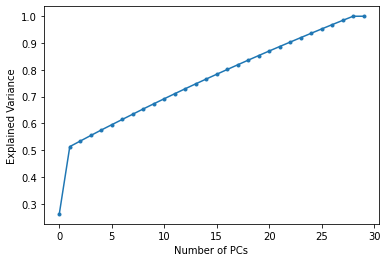

In [7]:
# Explained Variance Ratio
# 30 PCA dimensions (eigenvalues)
# eig_1, eig_2, eig_3, eig_4, ... 
# Explained_Variance_1 =  (eig_1) /(eig_1 + eig_2 + eig_3 + ... + eig_30)  
# Explained_Variance_2 =  (eig_1 + eig_2) / (eig_1 + eig_2 + eig_3 + ... + eig_30)  
# Explained_Variance_3 =  (eig_1 + eig_2 + eig_3) / (eig_1 + eig_2 + eig_3 + ... + eig_30)  
# .
# .
# .

plt.figure()
plt.plot(np.cumsum(pca.explained_variance_) / np.sum(pca.explained_variance_),'.-')
plt.xlabel('Number of PCs')
plt.ylabel('Explained Variance')
plt.show()

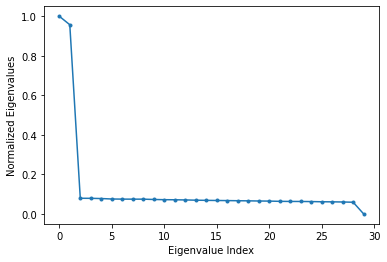

In [8]:
# Normalized Eigenvalues

normalized_eigenvalues = pca.explained_variance_ / pca.explained_variance_.max()

plt.figure()
plt.plot(normalized_eigenvalues,'.-')
plt.xlabel('Eigenvalue Index')
plt.ylabel('Normalized Eigenvalues')
plt.show()

How do we select how many PCs are sufficient? If we want reconstruction, then variance explained is sufficient. If we have some downstream task (e.g. detection/identification/classification), we can evaluate the number of PCs needed based on performance.


# Eigenfaces


The dataset used in this example is a preprocessed excerpt of the
"Labeled Faces in the Wild", aka LFW_:

  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz (233MB)


In [17]:
from time import time
import logging
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA
from sklearn.svm import SVC


print(__doc__)

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')


# #############################################################################
# Download the data, if not already on disk and load it as numpy arrays

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("sample height: %d" % h)
print("sample width: %d" % w)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)


Automatically created module for IPython interactive environment
Total dataset size:
n_samples: 1288
sample height: 50
sample width: 37
n_features: 1850
n_classes: 7


In [18]:
# #############################################################################
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150

print("Extracting the top %d eigenfaces from %d faces" % (n_components, X.shape[0]))
t0 = time()

# data: X
# (X - X.mean()) / X.std()  # X bar = X.mean(), where X = train database
pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True).fit(X)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))
# print("\n\n")
# print("PCA Project Matrix shape:", pca.components_.shape)
# print("Eigen Faces Shape after reshaping:", eigenfaces.shape)

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
# (1288, 1850)
# (150, 1850) # lower dimensional representation
# ( ) # w = (1,150), (150) eigenfaces 
X_pca = pca.transform(X)
print("done in %0.3fs" % (time() - t0))

# print("\n\n")
# print("Original Data Matrix Shape:", X.shape)
# print("Transformed Data Matrix Shape:", X_pca.shape)

Extracting the top 150 eigenfaces from 1288 faces
done in 0.540s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.027s


The faces: 


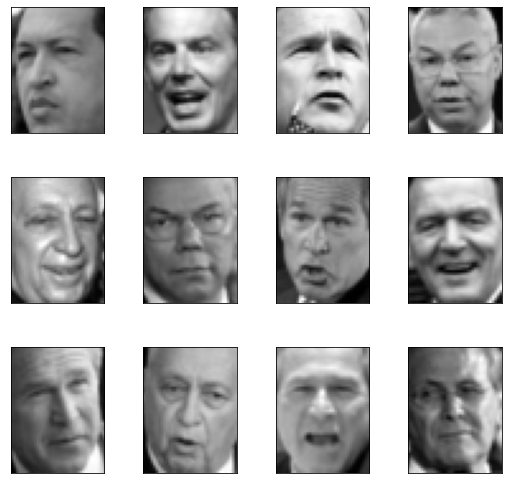

The eigenfaces faces: 


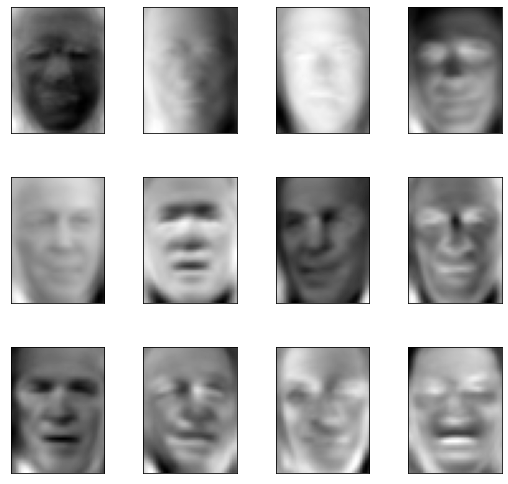

In [22]:
# #############################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.xticks(())
        plt.yticks(())

print("The faces: ")
plot_gallery(X, h, w)
plt.show()

# plot the gallery of the most significative eigenfaces
print("The eigenfaces faces: ")
plot_gallery(eigenfaces, h, w)

plt.show()

# Viola-Jones detection

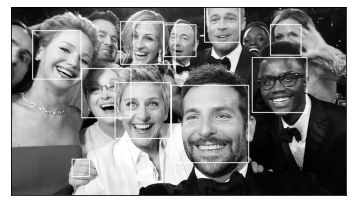

In [12]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

face_cascade = cv2.CascadeClassifier(path+'haarcascade_frontalface_default.xml')

img = cv2.imread(path+'oscar_selfie.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# detecMutliScale
#   Params: image – Matrix of the type CV_8U containing an image where objects are detected.
#           scaleFactor (1.1) – Parameter specifying how much the image size is reduced at each image scale.
#           minNeighbors (3) – Parameter specifying how many neighbors each candidate rectangle should have to retain it.
#           minSize (0,0) – Minimum possible object size. Objects smaller than that are ignored.
#           maxSize (0,0) – Maximum possible object size. Objects larger than that are ignored.

faces = face_cascade.detectMultiScale(gray, 1.1, 2)

for (x,y,w,h) in faces:
    gray = cv2.rectangle(gray,(x,y),(x+w,y+h),(255,0,0),2)

plt.imshow(gray, cmap="gray")
plt.xticks(())
plt.yticks(())
plt.show()